In [5]:
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
from nxcals.api.extraction.data.builders import *

import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [9]:
from scipy.optimize import curve_fit

def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

In [10]:
start = "2022-11-23 12:00:00.000"
end = "2022-11-28 05:00:00.000"

# Devices
* BXMWPC_2080/Acquisition#wireSpacingHorz

In [35]:
df_mwpc = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("BXMWPC_2080/Acquisition").build().toPandas()

In [58]:
selector = 'CPS.USER.EAST3'
df = df_mwpc.where(df_mwpc.selector == selector).dropna(subset=['acqStamp'])
df.reset_index(drop=True, inplace = True)
df.sort_values(by=["acqStamp"], inplace=True)

df["datetime"] = df["acqStamp"]/1000000000
df["datetime"] = [datetime.fromtimestamp(x) for x in df["datetime"]]

Text(0.5, 0, 'Distance [mm]')

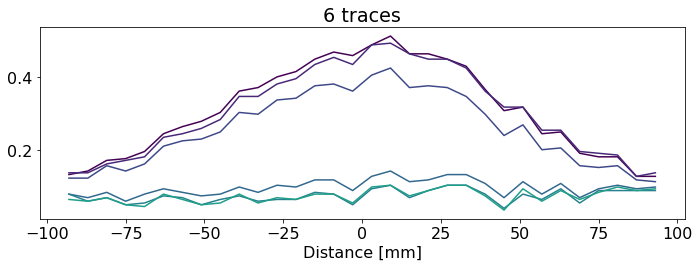

In [109]:
df_subset = df_mwpc.where( (df.datetime > datetime(2022, 11, 23, 14, 57)) & (df.datetime < datetime(2022, 11, 23, 15, 0)) ).dropna(subset=['acqStamp'])
df_subset.reset_index(drop = True, inplace = True)

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0,1,10)) #get 10 colors along the full range of hsv colormap

fig, ax = plt.subplots(tight_layout=True, figsize=(10,4))
ax.set_prop_cycle(color=colors) #set our 10 colors to the property cycle


for i in range(len(df_subset)):
    ax.plot(np.arange(-93,99,df_subset.wireSpacingHorz[0]), df_subset.profileHoriz[i]["elements"][0:32])
ax.set_title(f"{len(df_subset)} traces")
ax.set_xlabel("Distance [mm]")

In [114]:
df_subset = df_mwpc.where( (df.datetime > datetime(2022, 11, 23, 14, 50)) & (df.datetime < datetime(2022, 11, 23, 15, 0)) ).dropna(subset=['acqStamp'])
df_subset.reset_index(drop = True, inplace = True)

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0,1,len(df_subset))) #get x colors along colormap

fig, ax = plt.subplots(tight_layout=True, figsize=(10,4))
ax.set_prop_cycle(color=colors) #set our 10 colors to the property cycle


for i in range(len(df_subset)):
    ax.scatter(df.datetime[i], df_subset.profileHoriz[i]["elements"][0:32].sum())
ax.set_title(f"{len(df_subset)} traces")
ax.set_xlabel("Distance [mm]")

Text(0.5, 0, 'Distance [mm]')

# Gain dataframe

In [22]:
with open('rfko_gain_dataframe.pickle', 'rb') as handle:
    df_gain = pickle.load(handle)

In [122]:
t1 = datetime(2022, 11, 23, 14, 20)
t2 = datetime(2022, 11, 23, 16, 10)

(19319.597222222223, 19319.67361111111)

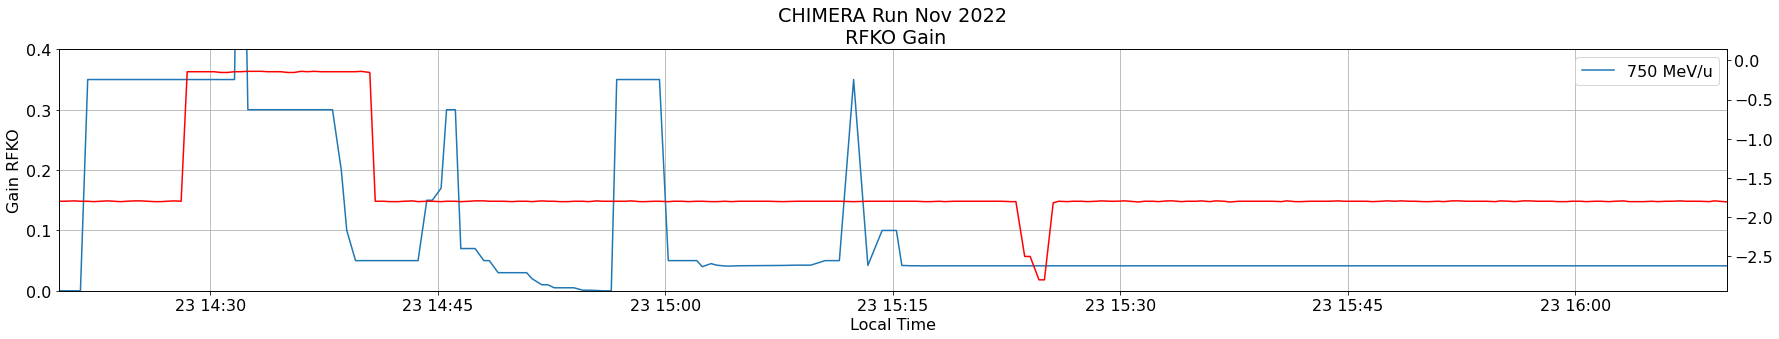

In [136]:
df_gain.sort_values(by=["timestamp"], inplace=True)
fig, ax = plt.subplots(tight_layout=True, figsize=(25,5))
ax2 = ax.twinx()
for energy in [750]:
    ax.plot(df_gain.timestamp.where(df_gain.energy==energy), df_gain.gain.where(df_gain.energy==energy), label=f"{energy} MeV/u")
    ax2.plot(df_gain.timestamp.where(df_gain.energy==energy), df_gain.where(df_gain.energy==energy).voltage, c="r", label=f"{energy} MeV/u")
ax.legend()
ax.set_xlabel("Local Time")
ax.set_ylabel("Gain RFKO")
ax.set_title("CHIMERA Run Nov 2022\n RFKO Gain")
ax.set_ylim(0, 0.4)
ax.grid()
ax.set_xlim([t1, t2])

In [137]:
df_subset = df_mwpc.where( (df.datetime > t1) & (df.datetime < t2) ).dropna(subset=['acqStamp'])
df_subset.reset_index(drop = True, inplace = True)

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0,1,len(df_subset))) #get x colors along colormap


fig, ax = plt.subplots(tight_layout=True, figsize=(25,5))
ax.set_prop_cycle(color=colors) #set our 10 colors to the property cycle


for i in range(len(df_subset)):
    ax.scatter(df.datetime[i], df_subset.profileHoriz[i]["elements"][0:32].sum())
ax.set_title(f"{len(df_subset)} traces")

ax2 = ax.twinx()
for energy in [750]:
    ax2.scatter(df_gain.timestamp.where((df_gain.energy==energy) & (df_gain.timestamp > t1) & (df_gain.timestamp < t2)), df_gain.gain.where((df_gain.energy==energy) & (df_gain.timestamp > t1) & (df_gain.timestamp < t2)), label=f"{energy} MeV/u")